In [2]:
import time
from typing import Any, Generator, Literal
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models as torch_model
import seaborn as sns
import os
%matplotlib inline

In [3]:
class Processing(object):
    def __init__(self, model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, optimizer: Any, loss: Any, device: Literal["cuda", "cpu"]) -> None:
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss = loss
        self.device = device

    def _train_loop(self) -> float:
        self.model.train()
        true = 0
        total = 0
        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()
            images = images.type(torch.float32)
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self.model(images)
            loss = self.loss(preds.type(torch.float32), F.one_hot(labels, num_classes=10).type(torch.float32))
            corrects = labels == preds.argmax(dim=1)
            true += int(corrects.sum())
            loss.backward()
            self.optimizer.step()
            total += len(preds)
        return true / total

    def _test_loop(self) -> float:
        self.model.eval()
        true = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_dataloader:
                self.optimizer.zero_grad()
                images = images.type(torch.float32)
                images = images.to(self.device)
                labels = labels.to(self.device)
                preds = self.model(images)
                corrects = labels == preds.argmax(dim=1)
                true += int(corrects.sum())
                total += len(preds)
        return true / total

    def train(self, epoch_num: int) -> Generator[nn.Module, None, None]:
        for ep in range(epoch_num):
            start = time.time()
            trainacc = self._train_loop()
            end = time.time()
            trtime = end - start
            start = time.time()
            testacc = self._test_loop()
            end = time.time()
            tetime = end - start
            print(f"Epoch {ep + 1}: train acc {trainacc}, time {trtime}; test acc {testacc}, time {tetime}")
            yield self.model

def train(model, device, train_dataloader, test_dataloader, optimizer, loss, epochs_num) -> None:
    model = model
    model = model.to(device)
    process = Processing(model, train_dataloader, test_dataloader, optimizer, loss, device)
    for model in process.train(epochs_num):
        print()

def last_shallow_layer(inim):
    return nn.Linear(inim, 10)

def last_deep_layer(inim):
    return nn.Sequential(nn.Linear(inim, inim // 2), nn.ReLU(), nn.Linear(inim // 2, 10))

In [9]:
nownet = torch_model.resnet50(weights = torch_model.ResNet50_Weights.IMAGENET1K_V2)
transform = torch_model.ResNet50_Weights.IMAGENET1K_V2.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
for param in nownet.parameters():
    param.requires_grad = False
nownet.fc = last_shallow_layer(2048)
optim = torch.optim.Adam(nownet.fc.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.7153, time 182.6400809288025; test acc 0.7694, time 38.62277698516846

Epoch 2: train acc 0.7905, time 184.01081371307373; test acc 0.7914, time 34.96769976615906

Epoch 3: train acc 0.80938, time 184.31797623634338; test acc 0.8028, time 34.67225360870361

Epoch 4: train acc 0.82084, time 183.7882719039917; test acc 0.8083, time 34.94883918762207

Epoch 5: train acc 0.82762, time 183.85935258865356; test acc 0.8085, time 36.43489170074463

Total time: 1098.295740365982


In [10]:
print(nownet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
transform = torch_model.ResNet50_Weights.IMAGENET1K_V2.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
nownet = torch_model.resnet50(weights = torch_model.ResNet50_Weights.IMAGENET1K_V2)
for param in nownet.parameters():
    param.requires_grad = False
nownet.fc = last_deep_layer(2048)
optim = torch.optim.Adam(nownet.fc.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.75454, time 187.3822581768036; test acc 0.7936, time 37.2804479598999

Epoch 2: train acc 0.81648, time 184.77966380119324; test acc 0.7986, time 35.80844569206238

Epoch 3: train acc 0.83268, time 184.17992281913757; test acc 0.8118, time 35.00686836242676

Epoch 4: train acc 0.85348, time 184.57145714759827; test acc 0.8042, time 34.993887186050415

Epoch 5: train acc 0.8745, time 185.54920721054077; test acc 0.8146, time 35.21817874908447

Total time: 1104.8120920658112


In [12]:
print(nownet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
nownet = torch_model.densenet161(torch_model.DenseNet161_Weights.DEFAULT)
transform = torch_model.DenseNet161_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
for param in nownet.parameters():
    param.requires_grad = False
nownet.classifier = last_shallow_layer(2208)
optim = torch.optim.Adam(nownet.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.7697, time 408.7180109024048; test acc 0.8142, time 73.51808571815491

Epoch 2: train acc 0.83096, time 408.63502502441406; test acc 0.8244, time 74.55933141708374

Epoch 3: train acc 0.84164, time 409.4424030780792; test acc 0.8325, time 74.01757097244263

Epoch 4: train acc 0.84808, time 405.841810464859; test acc 0.8319, time 73.93306684494019

Epoch 5: train acc 0.85272, time 406.79622864723206; test acc 0.8385, time 73.88168406486511

Total time: 2409.4080622196198


In [13]:
print(nownet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
import multiprocessing as mp

transform = torch_model.DenseNet161_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = mp.cpu_count() - 2, pin_memory = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = mp.cpu_count() - 2, pin_memory = True)
nownet = torch_model.densenet161(torch_model.DenseNet161_Weights.DEFAULT)
for param in nownet.parameters():
    param.requires_grad = False
nownet.classifier = last_deep_layer(2208)
optim = torch.optim.Adam(nownet.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.77854, time 510.8603091239929; test acc 0.8114, time 96.51889228820801

Epoch 2: train acc 0.83204, time 512.6317663192749; test acc 0.8249, time 94.14562344551086

Epoch 3: train acc 0.84642, time 515.2914764881134; test acc 0.8384, time 94.55045890808105

Epoch 4: train acc 0.8539, time 511.9939970970154; test acc 0.8343, time 93.87396693229675

Epoch 5: train acc 0.86492, time 510.4122779369354; test acc 0.8292, time 94.31769561767578

Total time: 3034.658679008484


In [15]:
print(nownet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [30]:
transform = torch_model.ShuffleNet_V2_X1_5_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
nownet = torch_model.shufflenet_v2_x1_5(torch_model.ShuffleNet_V2_X1_5_Weights.DEFAULT)
for param in nownet.parameters():
    param.requires_grad = False
nownet.fc = last_shallow_layer(1024)
optim = torch.optim.Adam(nownet.fc.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.73394, time 143.71517086029053; test acc 0.8038, time 29.160451650619507

Epoch 2: train acc 0.80648, time 130.81412410736084; test acc 0.8157, time 25.966106176376343

Epoch 3: train acc 0.82276, time 126.2863974571228; test acc 0.8264, time 24.592745304107666

Epoch 4: train acc 0.83092, time 131.24812388420105; test acc 0.8297, time 25.752572536468506

Epoch 5: train acc 0.83746, time 125.53611755371094; test acc 0.833, time 25.840858697891235

Total time: 788.9255719184875


In [31]:
print(nownet)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_

In [32]:
transform = torch_model.ShuffleNet_V2_X1_5_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
nownet = torch_model.shufflenet_v2_x1_5(torch_model.ShuffleNet_V2_X1_5_Weights.DEFAULT)
for param in nownet.parameters():
    param.requires_grad = False
nownet.fc = last_deep_layer(1024)
optim = torch.optim.Adam(nownet.fc.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 7)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Epoch 1: train acc 0.77768, time 133.22001576423645; test acc 0.8274, time 25.96157217025757

Epoch 2: train acc 0.83022, time 126.53642988204956; test acc 0.8182, time 26.052791118621826

Epoch 3: train acc 0.84232, time 132.7152965068817; test acc 0.8376, time 25.954312562942505

Epoch 4: train acc 0.85148, time 127.35500812530518; test acc 0.8336, time 25.9833664894104

Epoch 5: train acc 0.86494, time 126.86346697807312; test acc 0.8428, time 26.782444953918457

Epoch 6: train acc 0.8792, time 129.57689356803894; test acc 0.8461, time 25.99847435951233

Epoch 7: train acc 0.88882, time 128.08077478408813; test acc 0.8455, time 26.222192525863647

Total time: 1087.3156609535217


In [33]:
print(nownet)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_

In [36]:
transform = torch_model.ViT_B_16_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
nownet = torch_model.vit_b_16(torch_model.ViT_B_16_Weights.DEFAULT)
for param in nownet.parameters():
    param.requires_grad = False
nownet.heads = last_shallow_layer(768)
optim = torch.optim.Adam(nownet.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.9174, time 599.8911702632904; test acc 0.942, time 107.43665814399719

Epoch 2: train acc 0.94932, time 597.3661358356476; test acc 0.9463, time 107.75213360786438

Epoch 3: train acc 0.95486, time 600.2230079174042; test acc 0.9493, time 107.40995287895203

Epoch 4: train acc 0.95882, time 598.5641226768494; test acc 0.9503, time 108.37480592727661

Epoch 5: train acc 0.9606, time 598.777702331543; test acc 0.9523, time 107.43543410301208

Total time: 3533.318796634674


In [37]:
print(nownet)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [40]:
transform = torch_model.ViT_B_16_Weights.DEFAULT.transforms()
train_ds = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 2)
nownet = torch_model.vit_b_16(torch_model.ViT_B_16_Weights.DEFAULT)
for param in nownet.parameters():
    param.requires_grad = False
nownet.heads = last_deep_layer(768)
optim = torch.optim.Adam(nownet.parameters(), lr = 0.001)
start = time.time()
trained_model = train(nownet, "cuda", train_dl, test_dl, optim, torch.nn.CrossEntropyLoss(), 5)
end = time.time()
print(f"Total time: {end - start}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: train acc 0.9337, time 598.4225974082947; test acc 0.9459, time 107.46531248092651

Epoch 2: train acc 0.95764, time 599.3677146434784; test acc 0.9485, time 107.76068949699402

Epoch 3: train acc 0.96636, time 599.2987694740295; test acc 0.9506, time 107.73594784736633

Epoch 4: train acc 0.97588, time 600.2125504016876; test acc 0.9526, time 107.85113286972046

Epoch 5: train acc 0.98334, time 601.4601011276245; test acc 0.9527, time 107.3656280040741

Total time: 3537.030153274536


In [41]:
print(nownet)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

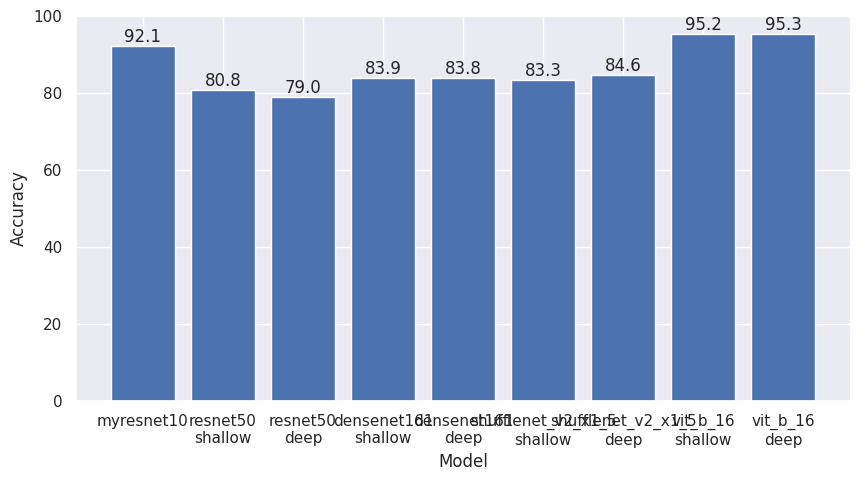

In [48]:
import matplotlib

model_names = ['myresnet10', 'resnet50\nshallow', 'resnet50\ndeep', 'densenet161\nshallow', 'densenet161\ndeep', 'shufflenet_v2_x1_5\nshallow', 'shufflenet_v2_x1_5\ndeep', 'vit_b_16\nshallow', 'vit_b_16\ndeep']
accuracies = [0.9213, 0.8085, 0.7899, 0.8385, 0.8384, 0.833, 0.8461, 0.9523, 0.9527]
accuracies = list(map(lambda x: round(x * 100,1), accuracies))
matplotlib.pyplot.figure(figsize=(10, 5))
matplotlib.pyplot.bar(model_names, accuracies)
for i in range(len(accuracies)):
    matplotlib.pyplot.text(i, accuracies[i], f"{accuracies[i]}", ha='center', va='bottom')
matplotlib.pyplot.xlabel('Model')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.show()